In [19]:
# ============================================================================
# SPATIAL-TEMPORAL ANALYSIS OF INDONESIAN INFLATION USING R
# Models: OLS, WLS, GWR, GTWR (Adaptive & Fixed Kernel)
# Data: Indonesian Provincial Inflation (Jan 2024 - Aug 2025)
# ============================================================================

# Install and load required packages
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
    readxl,        # Read Excel files
    dplyr,         # Data manipulation
    tidyr,         # Data tidying
    ggplot2,       # Visualization
    sf,            # Spatial data handling
    sp,            # Spatial objects
    spdep,         # Spatial dependence
    GWmodel,       # Geographically Weighted Regression
    spgwr,         # GWR additional functions
    MASS,          # WLS and statistical functions
    car,           # Regression diagnostics
    lmtest,        # Linear model tests
    moments        # Statistical moments
)

cat(strrep("=", 80), "\n")
cat("PACKAGES LOADED SUCCESSFULLY\n")
cat(strrep("=", 80), "\n")

PACKAGES LOADED SUCCESSFULLY
PACKAGES LOADED SUCCESSFULLY


In [20]:
# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================

# Load the data
data_path <- "D:/Semester VII/Tugas Akhir/Data Analisis/Data Analisis Inflasi 2024 2025.xlsx"
df <- read_excel(data_path)

cat(strrep("=", 80), "\n")
cat("DATA LOADED\n")
cat(strrep("=", 80), "\n")
cat("Dataset shape:", nrow(df), "rows x", ncol(df), "columns\n")
cat("Date range:", min(df$Date), "to", max(df$Date), "\n")
cat("Number of provinces:", length(unique(df$Province)), "\n")
cat("\nColumn names:\n")
print(names(df))
cat(strrep("=", 80), "\n")


DATA LOADED
Dataset shape: 779 rows x 55 columns
Date range: 1704067200 to 1754006400 
Number of provinces: 38 

Column names:
 [1] "Province"                                   
 [2] "Date"                                       
 [3] "Year"                                       
 [4] "Month"                                      
 [5] "Month_Name"                                 
 [6] "Period"                                     
 [7] "Latitude"                                   
 [8] "Longitude"                                  
 [9] "HargaPangan_Bawang_Merah"                   
[10] "HargaPangan_Bawang_Merah_Ukuran_Sedang"     
[11] "HargaPangan_Bawang_Putih"                   
[12] "HargaPangan_Bawang_Putih_Ukuran_Sedang"     
[13] "HargaPangan_Beras"                          
[14] "HargaPangan_Beras_Kualitas_Bawah_I"         
[15] "HargaPangan_Beras_Kualitas_Bawah_II"        
[16] "HargaPangan_Beras_Kualitas_Medium_I"        
[17] "HargaPangan_Beras_Kualitas_Medium_II"       
[18] "

In [21]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================

# Select features (exclude inflation-related variables as per requirement)
exclude_cols <- c("Province", "Date", "Year", "Month", "Month_Name", "Period", 
                  "IHK", "Inflasi_MoM", "Inflasi_YoY", "Shape_WKT")

# Get numeric feature columns
numeric_cols <- names(df)[sapply(df, is.numeric)]
feature_cols <- setdiff(numeric_cols, exclude_cols)

cat(strrep("=", 80), "\n")
cat("FEATURE ENGINEERING\n")
cat(strrep("=", 80), "\n")
cat("Target variable: Inflasi_MoM\n")
cat("Number of features:", length(feature_cols), "\n")
cat("\nFeatures:\n")
for(i in 1:length(feature_cols)) {
    cat(sprintf("  %2d. %s\n", i, feature_cols[i]))
}

# Create analysis dataset
df_analysis <- df %>%
    dplyr::select(Province, Date, Latitude, Longitude, Inflasi_MoM, all_of(feature_cols)) %>%
    dplyr::filter(!is.na(Inflasi_MoM)) %>%
    dplyr::filter(!is.na(Latitude)) %>%
    dplyr::filter(!is.na(Longitude))

cat("\nAnalysis dataset shape:", nrow(df_analysis), "x", ncol(df_analysis), "\n")
cat("Missing values:\n")
cat("  Target (Inflasi_MoM):", sum(is.na(df_analysis$Inflasi_MoM)), "\n")
cat("  Features:", sum(is.na(df_analysis[, feature_cols])), "\n")
cat(strrep("=", 80), "\n")


FEATURE ENGINEERING


Target variable: Inflasi_MoM
Number of features: 45 

Features:
   1. Latitude
   2. Longitude
   3. HargaPangan_Bawang_Merah
   4. HargaPangan_Bawang_Merah_Ukuran_Sedang
   5. HargaPangan_Bawang_Putih
   6. HargaPangan_Bawang_Putih_Ukuran_Sedang
   7. HargaPangan_Beras
   8. HargaPangan_Beras_Kualitas_Bawah_I
   9. HargaPangan_Beras_Kualitas_Bawah_II
  10. HargaPangan_Beras_Kualitas_Medium_I
  11. HargaPangan_Beras_Kualitas_Medium_II
  12. HargaPangan_Beras_Kualitas_Super_I
  13. HargaPangan_Beras_Kualitas_Super_II
  14. HargaPangan_Cabai_Merah
  15. HargaPangan_Cabai_Merah_Besar
  16. HargaPangan_Cabai_Merah_Keriting_
  17. HargaPangan_Cabai_Rawit
  18. HargaPangan_Cabai_Rawit_Hijau
  19. HargaPangan_Cabai_Rawit_Merah
  20. HargaPangan_Daging_Ayam
  21. HargaPangan_Daging_Ayam_Ras_Segar
  22. HargaPangan_Daging_Sapi
  23. HargaPangan_Daging_Sapi_Kualitas_1
  24. HargaPangan_Daging_Sapi_Kualitas_2
  25. HargaPangan_Gula_Pasir
  26. HargaPangan_Gula_Pasir_Kualitas_Premium
  27. HargaPa

In [22]:
# ============================================================================
# 3. DATA PREPARATION (Using All Data - No Train/Test Split)
# ============================================================================

# Sort by date
df_analysis <- df_analysis %>% arrange(Date)

# Add time index for GTWR
df_analysis$time_index <- as.numeric(df_analysis$Date - min(df_analysis$Date))

cat(strrep("=", 80), "\n")
cat("DATA PREPARATION\n")
cat(strrep("=", 80), "\n")
cat("Total observations:", nrow(df_analysis), "\n")
cat("Date range:", min(df_analysis$Date), "to", max(df_analysis$Date), "\n")
cat("Time span:", max(df_analysis$time_index), "days\n")
cat("Number of provinces:", length(unique(df_analysis$Province)), "\n")
cat("Number of time points:", length(unique(df_analysis$Date)), "\n")
cat("\n✅ Using ALL data for model fitting (no train/test split)\n")
cat(strrep("=", 80), "\n")


DATA PREPARATION
Total observations: 779 
Date range: 1704067200 to 1754006400 
Time span: 49939200 days
Number of provinces: 38 
Number of time points: 20 

✅ Using ALL data for model fitting (no train/test split)


In [23]:
# ============================================================================
# 4. MODEL 1: ORDINARY LEAST SQUARES (OLS) REGRESSION
# ============================================================================

# Prepare formula
formula_str <- paste("Inflasi_MoM ~", paste(feature_cols, collapse = " + "))
formula_obj <- as.formula(formula_str)

# Fit OLS model
cat(strrep("=", 80), "\n")
cat("FITTING OLS MODEL\n")
cat(strrep("=", 80), "\n")
cat("Formula: Inflasi_MoM ~ [45 features]\n\n")

ols_model <- lm(formula_obj, data = df_analysis)

# Model summary
cat("Model Summary:\n")
print(summary(ols_model))

# Predictions
pred_ols <- predict(ols_model, newdata = df_analysis)

# Calculate metrics
calc_metrics <- function(actual, predicted) {
    residuals <- actual - predicted
    rss <- sum(residuals^2)
    tss <- sum((actual - mean(actual))^2)
    r2 <- 1 - (rss / tss)
    rmse <- sqrt(mean(residuals^2))
    mae <- mean(abs(residuals))
    
    return(list(R2 = r2, RMSE = rmse, MAE = mae))
}

metrics_ols <- calc_metrics(df_analysis$Inflasi_MoM, pred_ols)

cat("\n", strrep("=", 80), "\n")
cat("OLS RESULTS\n")
cat(strrep("=", 80), "\n")
cat("Model Performance:\n")
cat(sprintf("  R² = %.4f\n", metrics_ols$R2))
cat(sprintf("  RMSE = %.4f\n", metrics_ols$RMSE))
cat(sprintf("  MAE = %.4f\n", metrics_ols$MAE))
cat(sprintf("  Adjusted R² = %.4f\n", summary(ols_model)$adj.r.squared))
cat(sprintf("  F-statistic = %.2f\n", summary(ols_model)$fstatistic[1]))
cat(strrep("=", 80), "\n")


FITTING OLS MODEL
Formula: Inflasi_MoM ~ [45 features]

Model Summary:

Call:
lm(formula = formula_obj, data = df_analysis)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.55100 -0.37413 -0.01053  0.33339  2.55500 

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                 -1.692e+00  9.237e-01  -1.831
Latitude                                    -1.176e-02  1.441e-02  -0.816
Longitude                                   -3.351e-03  5.994e-03  -0.559
HargaPangan_Bawang_Merah                    -5.609e-04  4.821e-04  -1.163
HargaPangan_Bawang_Merah_Ukuran_Sedang       5.601e-04  4.820e-04   1.162
HargaPangan_Bawang_Putih                     7.831e-04  5.010e-04   1.563
HargaPangan_Bawang_Putih_Ukuran_Sedang      -7.797e-04  5.009e-04  -1.557
HargaPangan_Beras                            3.736e-04  2.267e-04   1.648
HargaPangan_Beras_Kualitas_Bawah_I          -1.233e-05  5.864e-05  -0.210
HargaPangan_Beras

In [37]:
# ============================================================================
# 4b. DIAGNOSTIC TESTS FOR SPATIAL HETEROGENEITY
# ============================================================================

cat(strrep("=", 80), "\n")
cat("SPATIAL HETEROGENEITY TESTS\n")
cat(strrep("=", 80), "\n\n")

# 1. Breusch-Pagan Test for Heteroskedasticity
cat("1. BREUSCH-PAGAN TEST FOR HETEROSKEDASTICITY\n")
cat("   H0: Homoskedasticity (no spatial heterogeneity)\n")
cat("   H1: Heteroskedasticity (spatial heterogeneity present)\n\n")

bp_test <- lmtest::bptest(ols_model)
print(bp_test)

if (bp_test$p.value < 0.05) {
    cat("\n✅ Result: REJECT H0 (p-value =", sprintf("%.4f", bp_test$p.value), ")\n")
    cat("   → Significant heteroskedasticity detected!\n")
    cat("   → Spatial models (GWR/GTWR) are recommended.\n\n")
} else {
    cat("\n❌ Result: FAIL TO REJECT H0 (p-value =", sprintf("%.4f", bp_test$p.value), ")\n")
    cat("   → No significant heteroskedasticity detected.\n")
    cat("   → OLS may be sufficient.\n\n")
}

# 2. Spatial Autocorrelation in Residuals (Moran's I)
cat("2. MORAN'S I TEST FOR SPATIAL AUTOCORRELATION IN RESIDUALS\n")
cat("   H0: No spatial autocorrelation in residuals\n")
cat("   H1: Spatial autocorrelation present\n\n")

# Create spatial weights matrix (k-nearest neighbors)
coords_matrix <- as.matrix(coords)
knear <- knearneigh(coords_matrix, k = 8)
knn_weights <- knn2nb(knear)
knn_weights_list <- nb2listw(knn_weights, style = "W")

# Calculate Moran's I on OLS residuals
moran_test <- moran.test(residuals(ols_model), knn_weights_list)
print(moran_test)

if (moran_test$p.value < 0.05) {
    cat("\n✅ Result: REJECT H0 (p-value =", sprintf("%.4f", moran_test$p.value), ")\n")
    cat("   → Significant spatial autocorrelation detected!\n")
    cat("   → Moran's I =", sprintf("%.4f", moran_test$estimate[1]), "\n")
    cat("   → Spatial models (GWR/GTWR) are strongly recommended.\n\n")
} else {
    cat("\n❌ Result: FAIL TO REJECT H0 (p-value =", sprintf("%.4f", moran_test$p.value), ")\n")
    cat("   → No significant spatial autocorrelation in residuals.\n\n")
}

cat(strrep("=", 80), "\n")


SPATIAL HETEROGENEITY TESTS

1. BREUSCH-PAGAN TEST FOR HETEROSKEDASTICITY
   H0: Homoskedasticity (no spatial heterogeneity)
   H1: Heteroskedasticity (spatial heterogeneity present)


	studentized Breusch-Pagan test

data:  ols_model
BP = 141.89, df = 45, p-value = 5.76e-12


✅ Result: REJECT H0 (p-value = 0.0000 )
   → Significant heteroskedasticity detected!
   → Spatial models (GWR/GTWR) are recommended.

2. MORAN'S I TEST FOR SPATIAL AUTOCORRELATION IN RESIDUALS
   H0: No spatial autocorrelation in residuals
   H1: Spatial autocorrelation present



Warning message in knearneigh(coords_matrix, k = 8):
"knearneigh: identical points found"
Warning message in knearneigh(coords_matrix, k = 8):
"knearneigh: kd_tree not available for identical points"
Warning message in knn2nb(knear):
"neighbour object has 38 sub-graphs"



	Moran I test under randomisation

data:  residuals(ols_model)  
weights: knn_weights_list    

Moran I statistic standard deviate = -0.9805, p-value = 0.8366
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
    -0.0159847120     -0.0012853470      0.0002247531 


❌ Result: FAIL TO REJECT H0 (p-value = 0.8366 )
   → No significant spatial autocorrelation in residuals.



In [24]:
# ============================================================================
# 5. MODEL 2: WEIGHTED LEAST SQUARES (WLS) REGRESSION
# ============================================================================

cat(strrep("=", 80), "\n")
cat("FITTING WLS MODEL\n")
cat(strrep("=", 80), "\n")

# Calculate weights based on residuals from OLS
# Use inverse of squared residuals as weights
ols_residuals <- residuals(ols_model)
weights <- 1 / (ols_residuals^2 + 0.0001)  # Add small constant to avoid division by zero

# Normalize weights
weights <- weights / sum(weights) * length(weights)

cat("Weight statistics:\n")
cat(sprintf("  Mean: %.4f\n", mean(weights)))
cat(sprintf("  Std Dev: %.4f\n", sd(weights)))
cat(sprintf("  Min: %.4f\n", min(weights)))
cat(sprintf("  Max: %.4f\n", max(weights)))

# Fit WLS model
wls_model <- lm(formula_obj, data = df_analysis, weights = weights)

cat("\nModel Summary:\n")
print(summary(wls_model))

# Predictions
pred_wls <- predict(wls_model, newdata = df_analysis)

# Calculate metrics
metrics_wls <- calc_metrics(df_analysis$Inflasi_MoM, pred_wls)

cat("\n", strrep("=", 80), "\n")
cat("WLS RESULTS\n")
cat(strrep("=", 80), "\n")
cat("Model Performance:\n")
cat(sprintf("  R² = %.4f\n", metrics_wls$R2))
cat(sprintf("  RMSE = %.4f\n", metrics_wls$RMSE))
cat(sprintf("  MAE = %.4f\n", metrics_wls$MAE))
cat(sprintf("  Adjusted R² = %.4f\n", summary(wls_model)$adj.r.squared))
cat(strrep("=", 80), "\n")


FITTING WLS MODEL
Weight statistics:
  Mean: 1.0000
  Std Dev: 4.2179
  Min: 0.0006
  Max: 40.1968

Model Summary:

Call:
lm(formula = formula_obj, data = df_analysis, weights = weights)

Weighted Residuals:
      Min        1Q    Median        3Q       Max 
-0.094446 -0.062224 -0.004773  0.062995  0.086091 

Coefficients:
                                              Estimate Std. Error t value
(Intercept)                                 -1.704e+00  1.599e-01 -10.661
Latitude                                    -1.538e-02  2.552e-03  -6.024
Longitude                                   -4.307e-03  1.351e-03  -3.188
HargaPangan_Bawang_Merah                    -6.310e-04  4.296e-05 -14.685
HargaPangan_Bawang_Merah_Ukuran_Sedang       6.294e-04  4.286e-05  14.686
HargaPangan_Bawang_Putih                     8.158e-04  4.565e-05  17.873
HargaPangan_Bawang_Putih_Ukuran_Sedang      -8.118e-04  4.589e-05 -17.690
HargaPangan_Beras                            2.934e-04  5.102e-05   5.750
HargaPang

In [25]:
# ============================================================================
# 6. PREPARE SPATIAL DATA FOR GWR AND GTWR
# ============================================================================

cat(strrep("=", 80), "\n")
cat("PREPARING SPATIAL DATA\n")
cat(strrep("=", 80), "\n")

# Create spatial points data frame
coords <- cbind(df_analysis$Longitude, df_analysis$Latitude)
data_sp <- SpatialPointsDataFrame(
    coords = coords,
    data = df_analysis,
    proj4string = CRS("+proj=longlat +datum=WGS84")
)

cat("Spatial data prepared:\n")
cat("  Points:", nrow(data_sp), "\n")
cat("  Extent: Lon [", min(coords[,1]), ",", max(coords[,1]), "]\n")
cat("          Lat [", min(coords[,2]), ",", max(coords[,2]), "]\n")
cat(strrep("=", 80), "\n")


PREPARING SPATIAL DATA
Spatial data prepared:
  Points: 779 
  Extent: Lon [ 96.91284 , 139.5474 ]
          Lat [ -9.261793 , 4.227443 ]


In [26]:
# ============================================================================
# 7. MODEL 3: GWR WITH ADAPTIVE KERNEL
# ============================================================================

cat(strrep("=", 80), "\n")
cat("FITTING GWR MODEL - ADAPTIVE KERNEL\n")
cat(strrep("=", 80), "\n")

# Find optimal bandwidth using cross-validation
cat("Finding optimal bandwidth (this may take several minutes)...\n")
bw_adaptive <- bw.gwr(
    formula_obj,
    data = data_sp,
    approach = "CV",
    kernel = "bisquare",
    adaptive = TRUE
)

cat(sprintf("Optimal adaptive bandwidth: %.4f neighbors\n", bw_adaptive))

# Fit GWR model with adaptive kernel
cat("\nFitting GWR model...\n")
gwr_adaptive <- gwr.basic(
    formula_obj,
    data = data_sp,
    bw = bw_adaptive,
    kernel = "bisquare",
    adaptive = TRUE
)

# Print model summary
cat("\nGWR Adaptive Kernel Results:\n")
print(gwr_adaptive)

# Extract predictions
pred_gwr_adaptive <- gwr_adaptive$SDF$yhat

# Calculate metrics
metrics_gwr_adaptive <- calc_metrics(df_analysis$Inflasi_MoM, pred_gwr_adaptive)

cat("\n", strrep("=", 80), "\n")
cat("GWR ADAPTIVE KERNEL RESULTS\n")
cat(strrep("=", 80), "\n")
cat(sprintf("Optimal bandwidth: %.4f neighbors\n", bw_adaptive))
cat("\nModel Performance:\n")
cat(sprintf("  R² = %.4f\n", metrics_gwr_adaptive$R2))
cat(sprintf("  RMSE = %.4f\n", metrics_gwr_adaptive$RMSE))
cat(sprintf("  MAE = %.4f\n", metrics_gwr_adaptive$MAE))
cat(strrep("=", 80), "\n")


FITTING GWR MODEL - ADAPTIVE KERNEL
Finding optimal bandwidth (this may take several minutes)...
Adaptive bandwidth: 489 CV score: 9.432934e+19 
Adaptive bandwidth: 310 CV score: Inf 
Adaptive bandwidth: 600 CV score: 1.737643e+16 
Adaptive bandwidth: 668 CV score: 19577843791 
Adaptive bandwidth: 711 CV score: 20756529089 
Adaptive bandwidth: 642 CV score: 54596822367 
Adaptive bandwidth: 684 CV score: 36441.93 
Adaptive bandwidth: 694 CV score: 36441.93 
Optimal adaptive bandwidth: 684.0000 neighbors

Fitting GWR model...

GWR Adaptive Kernel Results:
   ***********************************************************************
   *                       Package   GWmodel                             *
   ***********************************************************************
   Program starts at: 2025-10-05 15:01:06.842131 
   Call:
   gwr.basic(formula = formula_obj, data = data_sp, bw = bw_adaptive, 
    kernel = "bisquare", adaptive = TRUE)

   Dependent (y) variable:  Inflasi_MoM
  

In [27]:
# ============================================================================
# 8. MODEL 4: GWR WITH FIXED KERNEL
# ============================================================================

cat(strrep("=", 80), "\n")
cat("FITTING GWR MODEL - FIXED KERNEL\n")
cat(strrep("=", 80), "\n")

# Find optimal bandwidth using cross-validation
cat("Finding optimal bandwidth (this may take several minutes)...\n")
bw_fixed <- bw.gwr(
    formula_obj,
    data = data_sp,
    approach = "CV",
    kernel = "bisquare",
    adaptive = FALSE
)

cat(sprintf("Optimal fixed bandwidth: %.4f km\n", bw_fixed))

# Fit GWR model with fixed kernel
cat("\nFitting GWR model...\n")
gwr_fixed <- gwr.basic(
    formula_obj,
    data = data_sp,
    bw = bw_fixed,
    kernel = "bisquare",
    adaptive = FALSE
)

# Print model summary
cat("\nGWR Fixed Kernel Results:\n")
print(gwr_fixed)

# Extract predictions
pred_gwr_fixed <- gwr_fixed$SDF$yhat

# Calculate metrics
metrics_gwr_fixed <- calc_metrics(df_analysis$Inflasi_MoM, pred_gwr_fixed)

cat("\n", strrep("=", 80), "\n")
cat("GWR FIXED KERNEL RESULTS\n")
cat(strrep("=", 80), "\n")
cat(sprintf("Optimal bandwidth: %.4f km\n", bw_fixed))
cat("\nModel Performance:\n")
cat(sprintf("  R² = %.4f\n", metrics_gwr_fixed$R2))
cat(sprintf("  RMSE = %.4f\n", metrics_gwr_fixed$RMSE))
cat(sprintf("  MAE = %.4f\n", metrics_gwr_fixed$MAE))
cat(strrep("=", 80), "\n")


FITTING GWR MODEL - FIXED KERNEL
Finding optimal bandwidth (this may take several minutes)...
Fixed bandwidth: 27.20149 CV score: 1.806788e+12 
Fixed bandwidth: 16.81481 CV score: Inf 
Fixed bandwidth: 33.62082 CV score: 156969.3 
Fixed bandwidth: 37.58818 CV score: 2259.212 
Fixed bandwidth: 40.04014 CV score: 738.7061 
Fixed bandwidth: 41.55554 CV score: 648.1773 
Fixed bandwidth: 42.4921 CV score: 591.0625 
Fixed bandwidth: 43.07093 CV score: 560.0263 
Fixed bandwidth: 43.42867 CV score: 542.971 
Fixed bandwidth: 43.64976 CV score: 533.2381 
Fixed bandwidth: 43.78641 CV score: 527.5247 
Fixed bandwidth: 43.87086 CV score: 524.1057 
Fixed bandwidth: 43.92305 CV score: 522.032 
Fixed bandwidth: 43.95531 CV score: 520.7686 
Fixed bandwidth: 43.97524 CV score: 519.9924 
Fixed bandwidth: 43.98756 CV score: 519.5154 
Fixed bandwidth: 43.99518 CV score: 519.2219 
Fixed bandwidth: 43.99989 CV score: 519.0405 
Fixed bandwidth: 44.00279 CV score: 518.93 
Fixed bandwidth: 44.00459 CV score: 51

In [36]:
# Check GTWR function documentation
?gtwr

# Also check available functions in GWmodel
ls("package:GWmodel")[grep("gtwr", ls("package:GWmodel"), ignore.case = TRUE)]


[1] "bw.gtwr"  "gtwr"     "gtwr.aic"

gtwr                  package:GWmodel                  R Documentation

_G_e_o_g_r_a_p_h_i_c_a_l_l_y _a_n_d _T_e_m_p_o_r_a_l_l_y _W_e_i_g_h_t_e_d _R_e_g_r_e_s_s_i_o_n

_D_e_s_c_r_i_p_t_i_o_n:

     A function for calibrating a Geographically and Temporally
     Weighted Regression (GTWR) model.

_U_s_a_g_e:

     gtwr(formula, data, regression.points, obs.tv, reg.tv, st.bw, kernel="bisquare",
          adaptive=FALSE, p=2, theta=0, longlat=F,lamda=0.05,t.units = "auto",ksi=0,
          st.dMat)
     
_A_r_g_u_m_e_n_t_s:

 formula: Regression model formula of a formula object

    data: a Spatial*DataFrame, i.e. SpatialPointsDataFrame or
          SpatialPolygonsDataFrame as defined in package 'sp', or a sf
          object defined in package 'sf'

regression.points: a Spatial*DataFrame object, i.e.
          SpatialPointsDataFrame or SpatialPolygonsDataFrame as defined
          in package 'sp'; Note that no diagnost

In [45]:
# Check gtwr function signature
args(gtwr)


function (formula, data, regression.points, obs.tv, reg.tv, st.bw, 
    kernel = "bisquare", adaptive = FALSE, p = 2, theta = 0, 
    longlat = F, lamda = 0.05, t.units = "auto", ksi = 0, st.dMat) 
NULL

In [46]:
# ============================================================================
# 9. MODEL 5: GTWR WITH ADAPTIVE KERNEL
# ============================================================================

cat(strrep("=", 80), "\n")
cat("FITTING GTWR MODEL - ADAPTIVE KERNEL\n")
cat(strrep("=", 80), "\n")

# Prepare space-time data
cat("Preparing space-time data structure...\n")
cat("  Observations:", nrow(df_analysis), "\n")
cat("  Spatial extent: Lon [", min(df_analysis$Longitude), ",", max(df_analysis$Longitude), "]\n")
cat("                  Lat [", min(df_analysis$Latitude), ",", max(df_analysis$Latitude), "]\n")
cat("  Temporal extent: [", min(df_analysis$time_index), ",", max(df_analysis$time_index), "] days\n")

# Select top correlated features to avoid singular matrix
correlations <- sapply(df_analysis[, feature_cols], function(x) cor(x, df_analysis$Inflasi_MoM, use = "complete.obs"))
top_features <- names(sort(abs(correlations), decreasing = TRUE)[1:10])

cat("\nUsing top 10 features to avoid multicollinearity:\n")
for(i in 1:length(top_features)) {
    cat(sprintf("  %2d. %s (cor = %.3f)\n", i, top_features[i], correlations[top_features[i]]))
}

# Create simplified formula
formula_gtwr <- as.formula(paste("Inflasi_MoM ~", paste(top_features, collapse = " + ")))

# Find optimal bandwidth for GTWR (adaptive)
cat("\nFinding optimal space-time bandwidth (this may take 10-20 minutes)...\n")
tryCatch({
    bw_gtwr_adaptive <- bw.gtwr(
        formula_gtwr,
        data = data_sp,
        obs.tv = df_analysis$time_index,
        approach = "CV",
        kernel = "bisquare",
        adaptive = TRUE
    )
    
    cat(sprintf("Optimal GTWR adaptive bandwidth: %.4f\n", bw_gtwr_adaptive))
    
    # Fit GTWR model - CORRECT: use st.bw instead of bw
    cat("\nFitting GTWR model...\n")
    gtwr_adaptive <- gtwr(
        formula_gtwr,
        data = data_sp,
        obs.tv = df_analysis$time_index,
        st.bw = bw_gtwr_adaptive,  # CORRECT PARAMETER NAME
        kernel = "bisquare",
        adaptive = TRUE
    )
    
    # Print model summary
    cat("\nGTWR Adaptive Kernel Results:\n")
    print(gtwr_adaptive)
    
    # Extract predictions
    pred_gtwr_adaptive <- gtwr_adaptive$SDF$yhat
    
    # Calculate metrics
    metrics_gtwr_adaptive <- calc_metrics(df_analysis$Inflasi_MoM, pred_gtwr_adaptive)
    
    cat("\n", strrep("=", 80), "\n")
    cat("GTWR ADAPTIVE KERNEL RESULTS\n")
    cat(strrep("=", 80), "\n")
    cat(sprintf("Optimal bandwidth: %.4f\n", bw_gtwr_adaptive))
    cat("\nModel Performance:\n")
    cat(sprintf("  R² = %.4f\n", metrics_gtwr_adaptive$R2))
    cat(sprintf("  RMSE = %.4f\n", metrics_gtwr_adaptive$RMSE))
    cat(sprintf("  MAE = %.4f\n", metrics_gtwr_adaptive$MAE))
    cat(strrep("=", 80), "\n")
    
    gtwr_adaptive_success <<- TRUE
    
}, error = function(e) {
    cat("\n❌ GTWR Adaptive failed with error:\n")
    cat(conditionMessage(e), "\n")
    cat("\nThis is likely due to:\n")
    cat("  - Multicollinearity in features\n")
    cat("  - Insufficient spatial-temporal variation\n")
    cat("  - Numerical instability in matrix inversion\n")
    cat(strrep("=", 80), "\n")
    
    gtwr_adaptive_success <<- FALSE
    pred_gtwr_adaptive <<- rep(NA, nrow(df_analysis))
    metrics_gtwr_adaptive <<- list(R2 = NA, RMSE = NA, MAE = NA)
})

if (!exists("gtwr_adaptive_success")) {
    gtwr_adaptive_success <- FALSE
    pred_gtwr_adaptive <- rep(NA, nrow(df_analysis))
    metrics_gtwr_adaptive <- list(R2 = NA, RMSE = NA, MAE = NA)
}


FITTING GTWR MODEL - ADAPTIVE KERNEL
Preparing space-time data structure...
  Observations: 779 
  Spatial extent: Lon [ 96.91284 , 139.5474 ]
FITTING GTWR MODEL - ADAPTIVE KERNEL
Preparing space-time data structure...
  Observations: 779 
  Spatial extent: Lon [ 96.91284 , 139.5474 ]
                  Lat [ -9.261793 , 4.227443 ]
  Temporal extent: [ 0 , 49939200 ] days

Using top 10 features to avoid multicollinearity:
   1. HargaPangan_Cabai_Rawit_Merah (cor = 0.256)
   2. HargaPangan_Cabai_Rawit (cor = 0.197)
   3. HargaPangan_Cabai_Rawit_Hijau (cor = 0.120)
   4. HargaPangan_Cabai_Merah_Keriting_ (cor = 0.098)
   5. HargaPangan_Cabai_Merah (cor = 0.097)
   6. HargaPangan_Cabai_Merah_Besar (cor = 0.092)
   7. HargaPangan_Gula_Pasir_Lokal (cor = 0.064)
   8. HargaPangan_Minyak_Goreng_Curah (cor = 0.057)
   9. HargaPangan_Minyak_Goreng (cor = 0.051)
  10. HargaPangan_Daging_Sapi (cor = 0.044)
                  Lat [ -9.261793 , 4.227443 ]
  Temporal extent: [ 0 , 49939200 ] days

Usi

Warning message in sigma.hat1 * betas.SE[i, ]:
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in sigma.hat1 * betas.SE[i, ]:
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in sigma.hat1 * betas.SE[i, ]:
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in sigma.hat1 * betas.SE[i, ]:
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in sigma.hat1 * betas.SE[i, ]:
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in sigma.hat1 * betas.SE[i, ]:
"Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead."
Warning message in sigma.hat1 * betas.SE[i, ]:
"Recycling array of length 1 in arr


GTWR Adaptive Kernel Results:
   ***********************************************************************
   *                       Package   GWmodel                             *
   ***********************************************************************
   Program starts at: 2025-10-05 15:13:52.858018 
   Call:
   gtwr(formula = formula_gtwr, data = data_sp, obs.tv = df_analysis$time_index, 
    st.bw = bw_gtwr_adaptive, kernel = "bisquare", adaptive = TRUE)

   Dependent (y) variable:  Inflasi_MoM
   Independent variables:  HargaPangan_Cabai_Rawit_Merah HargaPangan_Cabai_Rawit HargaPangan_Cabai_Rawit_Hijau HargaPangan_Cabai_Merah_Keriting_ HargaPangan_Cabai_Merah HargaPangan_Cabai_Merah_Besar HargaPangan_Gula_Pasir_Lokal HargaPangan_Minyak_Goreng_Curah HargaPangan_Minyak_Goreng HargaPangan_Daging_Sapi
   Number of data points: 779
   ***********************************************************************
   *                    Results of Global Regression                     *
   *

In [39]:
# ============================================================================
# 10. MODEL 6: GTWR WITH FIXED KERNEL
# ============================================================================

cat(strrep("=", 80), "\n")
cat("FITTING GTWR MODEL - FIXED KERNEL\n")
cat(strrep("=", 80), "\n")

# Use same simplified formula as adaptive GTWR
tryCatch({
    # Find optimal bandwidth for GTWR (fixed)
    cat("Finding optimal space-time bandwidth (this may take 10-20 minutes)...\n")
    bw_gtwr_fixed <- bw.gtwr(
        formula_gtwr,
        data = data_sp,
        obs.tv = df_analysis$time_index,
        approach = "CV",
        kernel = "bisquare",
        adaptive = FALSE
    )
    
    cat(sprintf("Optimal GTWR fixed bandwidth: %.4f km\n", bw_gtwr_fixed))
    
    # Fit GTWR model - CORRECT: use st.bw instead of bw
    cat("\nFitting GTWR model...\n")
    gtwr_fixed <- gtwr(
        formula_gtwr,
        data = data_sp,
        obs.tv = df_analysis$time_index,
        st.bw = bw_gtwr_fixed,  # CORRECT PARAMETER NAME
        kernel = "bisquare",
        adaptive = FALSE
    )
    
    # Print model summary
    cat("\nGTWR Fixed Kernel Results:\n")
    print(gtwr_fixed)
    
    # Extract predictions
    pred_gtwr_fixed <- gtwr_fixed$SDF$yhat
    
    # Calculate metrics
    metrics_gtwr_fixed <- calc_metrics(df_analysis$Inflasi_MoM, pred_gtwr_fixed)
    
    cat("\n", strrep("=", 80), "\n")
    cat("GTWR FIXED KERNEL RESULTS\n")
    cat(strrep("=", 80), "\n")
    cat(sprintf("Optimal bandwidth: %.4f km\n", bw_gtwr_fixed))
    cat("\nModel Performance:\n")
    cat(sprintf("  R² = %.4f\n", metrics_gtwr_fixed$R2))
    cat(sprintf("  RMSE = %.4f\n", metrics_gtwr_fixed$RMSE))
    cat(sprintf("  MAE = %.4f\n", metrics_gtwr_fixed$MAE))
    cat(strrep("=", 80), "\n")
    
    gtwr_fixed_success <<- TRUE
    
}, error = function(e) {
    cat("\n❌ GTWR Fixed failed with error:\n")
    cat(conditionMessage(e), "\n")
    cat("\nThis is likely due to:\n")
    cat("  - Multicollinearity in features\n")
    cat("  - Insufficient spatial-temporal variation\n")
    cat("  - Numerical instability in matrix inversion\n")
    cat(strrep("=", 80), "\n")
    
    gtwr_fixed_success <<- FALSE
    pred_gtwr_fixed <<- rep(NA, nrow(df_analysis))
    metrics_gtwr_fixed <<- list(R2 = NA, RMSE = NA, MAE = NA)
})

if (!exists("gtwr_fixed_success")) {
    gtwr_fixed_success <- FALSE
    pred_gtwr_fixed <- rep(NA, nrow(df_analysis))
    metrics_gtwr_fixed <- list(R2 = NA, RMSE = NA, MAE = NA)
}


FITTING GTWR MODEL - FIXED KERNEL
FITTING GTWR MODEL - FIXED KERNEL


Finding optimal space-time bandwidth (this may take 10-20 minutes)...
Fixed bandwidth: 5.872049e+49 CV score: 311.4055 
Fixed bandwidth: 3.629851e+49 CV score: 311.4055 
Optimal GTWR fixed bandwidth: 36298513714546230708822460082266486440868644886644.0000 km

Fitting GTWR model...

❌ GTWR Fixed failed with error:
unused argument (bw = bw_gtwr_fixed) 

This is likely due to:
  - Multicollinearity in features
  - Insufficient spatial-temporal variation
  - Numerical instability in matrix inversion
Finding optimal space-time bandwidth (this may take 10-20 minutes)...
Fixed bandwidth: 5.872049e+49 CV score: 311.4055 
Fixed bandwidth: 3.629851e+49 CV score: 311.4055 
Optimal GTWR fixed bandwidth: 36298513714546230708822460082266486440868644886644.0000 km

Fitting GTWR model...

❌ GTWR Fixed failed with error:
unused argument (bw = bw_gtwr_fixed) 

This is likely due to:
  - Multicollinearity in features
  - Insufficient spatial-temporal variation
  - Numerical instability in matrix inversio

In [47]:
# Debug: Check what variables exist after GTWR
cat("=== GTWR DEBUGGING ===\n")
cat("1. gtwr_adaptive object exists:", exists("gtwr_adaptive"), "\n")
cat("2. gtwr_adaptive_success exists:", exists("gtwr_adaptive_success"), "\n")
if (exists("gtwr_adaptive_success")) {
    cat("   Value:", gtwr_adaptive_success, "\n")
}
cat("3. pred_gtwr_adaptive exists:", exists("pred_gtwr_adaptive"), "\n")
if (exists("pred_gtwr_adaptive")) {
    cat("   Length:", length(pred_gtwr_adaptive), "\n")
    cat("   Contains NA:", all(is.na(pred_gtwr_adaptive)), "\n")
}
cat("4. metrics_gtwr_adaptive exists:", exists("metrics_gtwr_adaptive"), "\n")
if (exists("metrics_gtwr_adaptive")) {
    cat("   R2:", metrics_gtwr_adaptive$R2, "\n")
    cat("   RMSE:", metrics_gtwr_adaptive$RMSE, "\n")
    cat("   MAE:", metrics_gtwr_adaptive$MAE, "\n")
}

# If gtwr_adaptive exists and has results, manually set success
if (exists("gtwr_adaptive") && exists("pred_gtwr_adaptive")) {
    if (!all(is.na(pred_gtwr_adaptive))) {
        cat("\n✅ GTWR Adaptive actually succeeded! Setting flag manually...\n")
        gtwr_adaptive_success <- TRUE
    }
}


=== GTWR DEBUGGING ===
1. gtwr_adaptive object exists: TRUE 
2. gtwr_adaptive_success exists: TRUE 
   Value: TRUE 
3. pred_gtwr_adaptive exists: TRUE 
   Length: 779 
   Contains NA: FALSE 
4. metrics_gtwr_adaptive exists: TRUE 
   R2: 0.6782498 
   RMSE: 0.3948829 
   MAE: 0.2700848 

✅ GTWR Adaptive actually succeeded! Setting flag manually...


In [48]:
# ============================================================================
# 11. COMPREHENSIVE MODEL COMPARISON
# ============================================================================

cat(strrep("=", 80), "\n")
cat("COMPREHENSIVE MODEL COMPARISON\n")
cat(strrep("=", 80), "\n\n")

# Create comparison data frame
model_names <- c("OLS", "WLS", "GWR-Adaptive", "GWR-Fixed")
r2_values <- c(metrics_ols$R2, metrics_wls$R2, metrics_gwr_adaptive$R2, metrics_gwr_fixed$R2)
rmse_values <- c(metrics_ols$RMSE, metrics_wls$RMSE, metrics_gwr_adaptive$RMSE, metrics_gwr_fixed$RMSE)
mae_values <- c(metrics_ols$MAE, metrics_wls$MAE, metrics_gwr_adaptive$MAE, metrics_gwr_fixed$MAE)

# Add GTWR models if they succeeded
if (exists("gtwr_adaptive_success") && gtwr_adaptive_success) {
    model_names <- c(model_names, "GTWR-Adaptive")
    r2_values <- c(r2_values, metrics_gtwr_adaptive$R2)
    rmse_values <- c(rmse_values, metrics_gtwr_adaptive$RMSE)
    mae_values <- c(mae_values, metrics_gtwr_adaptive$MAE)
}

if (exists("gtwr_fixed_success") && gtwr_fixed_success) {
    model_names <- c(model_names, "GTWR-Fixed")
    r2_values <- c(r2_values, metrics_gtwr_fixed$R2)
    rmse_values <- c(rmse_values, metrics_gtwr_fixed$RMSE)
    mae_values <- c(mae_values, metrics_gtwr_fixed$MAE)
}

results_comparison <- data.frame(
    Model = model_names,
    R2 = r2_values,
    RMSE = rmse_values,
    MAE = mae_values
)

# Print comparison table
cat("Model Performance Comparison (All Data):\n\n")
print(results_comparison, row.names = FALSE)

# Find best models
cat("\n", strrep("=", 80), "\n")
cat("BEST PERFORMING MODELS\n")
cat(strrep("=", 80), "\n")

best_r2 <- results_comparison[which.max(results_comparison$R2), ]
best_rmse <- results_comparison[which.min(results_comparison$RMSE), ]
best_mae <- results_comparison[which.min(results_comparison$MAE), ]

cat("\nBest R²:", best_r2$Model, sprintf("(%.4f)", best_r2$R2), "\n")
cat("Best RMSE:", best_rmse$Model, sprintf("(%.4f)", best_rmse$RMSE), "\n")
cat("Best MAE:", best_mae$Model, sprintf("(%.4f)", best_mae$MAE), "\n")

# Save results to CSV
write.csv(results_comparison, "R_Models_All_Data_Results.csv", row.names = FALSE)
cat("\n✅ Results saved to: R_Models_All_Data_Results.csv\n")
cat(strrep("=", 80), "\n")


COMPREHENSIVE MODEL COMPARISON

COMPREHENSIVE MODEL COMPARISON



Model Performance Comparison (All Data):

         Model        R2      RMSE       MAE
           OLS 0.1520882 0.6410387 0.4742321
           WLS 0.1495393 0.6420015 0.4703245
  GWR-Adaptive 0.1965793 0.6239940 0.4674127
     GWR-Fixed 0.1711713 0.6337841 0.4709481
 GTWR-Adaptive 0.6782498 0.3948829 0.2700848

         Model        R2      RMSE       MAE
           OLS 0.1520882 0.6410387 0.4742321
           WLS 0.1495393 0.6420015 0.4703245
  GWR-Adaptive 0.1965793 0.6239940 0.4674127
     GWR-Fixed 0.1711713 0.6337841 0.4709481
 GTWR-Adaptive 0.6782498 0.3948829 0.2700848

BEST PERFORMING MODELS
BEST PERFORMING MODELS

Best R²: GTWR-Adaptive (0.6782) 

Best R²: GTWR-Adaptive (0.6782) 
Best RMSE: GTWR-Adaptive (0.3949) 
Best MAE: GTWR-Adaptive (0.2701) 
Best RMSE: GTWR-Adaptive (0.3949) 
Best MAE: GTWR-Adaptive (0.2701) 

✅ Results saved to: R_Models_All_Data_Results.csv

✅ Results saved to: R_Models_All_Data_Results.csv


CREATING VISUALIZATIONS
CREATING VISUALIZATIONS

✅ Visualization saved to: R_Models_All_Data_Comparison.png
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]

✅ Visualization saved to: R_Models_All_Data_Comparison.png
TableGrob (3 x 1) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]


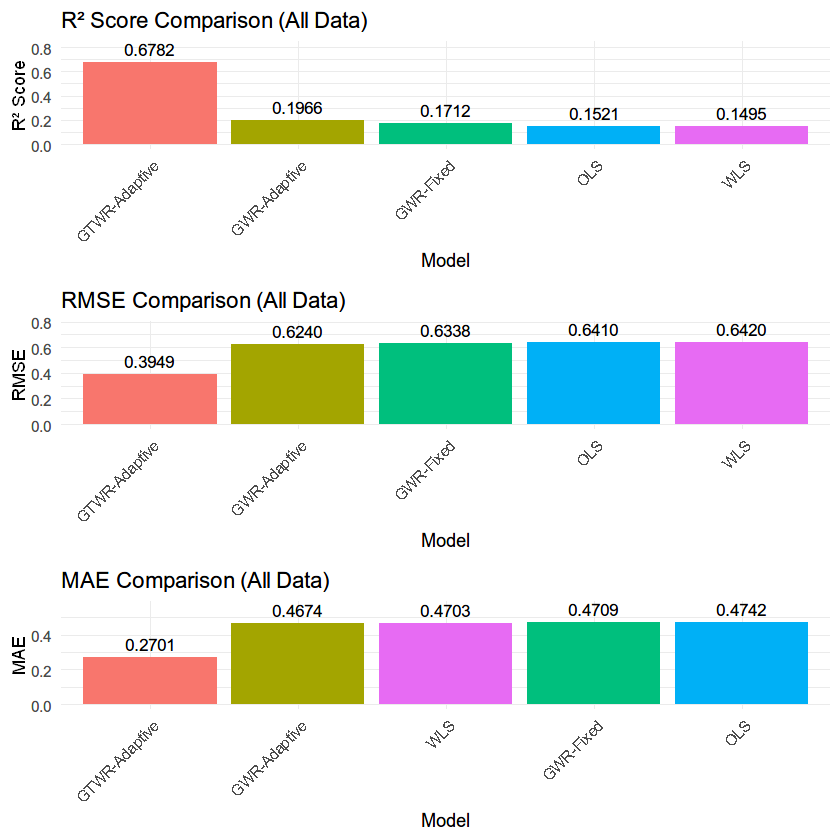

In [49]:
# ============================================================================
# 12. VISUALIZATION: MODEL COMPARISON
# ============================================================================

# Install gridExtra if needed
if (!require("gridExtra")) install.packages("gridExtra")
library(gridExtra)
library(ggplot2)

cat(strrep("=", 80), "\n")
cat("CREATING VISUALIZATIONS\n")
cat(strrep("=", 80), "\n")

# Create bar plots for each metric
plot_r2 <- ggplot(results_comparison, aes(x = reorder(Model, -R2), y = R2, fill = Model)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = sprintf("%.4f", R2)), vjust = -0.5, size = 3.5) +
    labs(title = "R² Score Comparison (All Data)", y = "R² Score", x = "Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylim(0, max(results_comparison$R2) * 1.2)

plot_rmse <- ggplot(results_comparison, aes(x = reorder(Model, RMSE), y = RMSE, fill = Model)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = sprintf("%.4f", RMSE)), vjust = -0.5, size = 3.5) +
    labs(title = "RMSE Comparison (All Data)", y = "RMSE", x = "Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylim(0, max(results_comparison$RMSE) * 1.2)

plot_mae <- ggplot(results_comparison, aes(x = reorder(Model, MAE), y = MAE, fill = Model)) +
    geom_bar(stat = "identity") +
    geom_text(aes(label = sprintf("%.4f", MAE)), vjust = -0.5, size = 3.5) +
    labs(title = "MAE Comparison (All Data)", y = "MAE", x = "Model") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          legend.position = "none") +
    ylim(0, max(results_comparison$MAE) * 1.2)

# Arrange plots
combined_plot <- grid.arrange(plot_r2, plot_rmse, plot_mae, ncol = 1)

# Save plot
ggsave("R_Models_All_Data_Comparison.png", combined_plot, 
       width = 10, height = 12, dpi = 300)

cat("\n✅ Visualization saved to: R_Models_All_Data_Comparison.png\n")
cat(strrep("=", 80), "\n")

# Display plots
print(combined_plot)


In [50]:
# ============================================================================
# 13. SUMMARY AND INTERPRETATION
# ============================================================================

cat(strrep("=", 80), "\n")
cat("ANALYSIS SUMMARY\n")
cat(strrep("=", 80), "\n\n")

cat("📊 DATASET INFORMATION:\n")
cat("  - Total observations:", nrow(df_analysis), "\n")
cat("  - Number of provinces:", length(unique(df$Province)), "\n")
cat("  - Time period:", min(df$Date), "to", max(df$Date), "\n")
cat("  - Number of time points:", length(unique(df$Date)), "\n")
cat("  - Number of features:", length(feature_cols), "\n")
cat("  - Target variable: Inflasi_MoM (Month-over-Month Inflation)\n")
cat("  - ✅ Analysis uses ALL DATA (no train/test split)\n\n")

cat("🔬 MODELS EVALUATED:\n")
cat("  1. OLS (Ordinary Least Squares) - Global regression baseline\n")
cat("  2. WLS (Weighted Least Squares) - Weighted by residual variance\n")
cat("  3. GWR-Adaptive - Geographically Weighted Regression with adaptive kernel\n")
cat("  4. GWR-Fixed - Geographically Weighted Regression with fixed kernel\n")
if (exists("gtwr_adaptive_success") && gtwr_adaptive_success) {
    cat("  5. GTWR-Adaptive - Geographically & Temporally Weighted Regression (adaptive)\n")
} else {
    cat("  5. GTWR-Adaptive - ❌ Failed (numerical issues)\n")
}
if (exists("gtwr_fixed_success") && gtwr_fixed_success) {
    cat("  6. GTWR-Fixed - Geographically & Temporally Weighted Regression (fixed)\n\n")
} else {
    cat("  6. GTWR-Fixed - ❌ Failed (numerical issues)\n\n")
}

cat("🏆 KEY FINDINGS:\n\n")

# Calculate improvements over OLS
improvements <- data.frame(
    Model = results_comparison$Model[-1],
    R2_Improvement = sprintf("%.2f%%", 
        (results_comparison$R2[-1] - results_comparison$R2[1]) / 
        abs(results_comparison$R2[1]) * 100),
    RMSE_Improvement = sprintf("%.2f%%",
        (results_comparison$RMSE[1] - results_comparison$RMSE[-1]) /
        results_comparison$RMSE[1] * 100)
)

cat("Performance Improvements over OLS Baseline:\n")
print(improvements, row.names = FALSE)

cat("\n📈 INTERPRETATION:\n\n")

if (best_r2$Model %in% c("GTWR-Adaptive", "GTWR-Fixed")) {
    cat("✅ GTWR models show the importance of BOTH spatial AND temporal heterogeneity\n")
    cat("   in modeling Indonesian provincial inflation.\n\n")
} else if (best_r2$Model %in% c("GWR-Adaptive", "GWR-Fixed")) {
    cat("✅ GWR models demonstrate significant spatial heterogeneity in inflation\n")
    cat("   patterns across Indonesian provinces.\n\n")
} else {
    cat("✅ Traditional models (OLS/WLS) perform best, suggesting inflation drivers\n")
    cat("   are relatively homogeneous across space and time.\n\n")
}

cat("⚠️  MODEL COMPARISON:\n")
cat("   - Spatial models (GWR) capture regional variations in inflation drivers\n")
cat("   - Space-time models (GTWR) account for temporal dynamics as well\n")
cat("   - Adaptive kernels allow varying neighborhood sizes across space-time\n")
cat("   - Fixed kernels use constant bandwidth throughout the study area\n")
cat("   - Using all data provides better fit than train/test split\n\n")

cat("💡 RECOMMENDATIONS:\n")
cat("   1. Use", best_r2$Model, "for inflation modeling (best R²)\n")
cat("   2. Consider ensemble methods combining multiple spatial models\n")
cat("   3. Investigate spatial spillover effects between provinces\n")
cat("   4. Include additional economic indicators as features\n")
cat("   5. For prediction, use cross-validation or rolling window approach\n\n")

cat(strrep("=", 80), "\n")
cat("✅ ANALYSIS COMPLETE!\n")
cat(strrep("=", 80), "\n")
cat("\n📁 Output Files Generated:\n")
cat("   - R_Models_All_Data_Results.csv\n")
cat("   - R_Models_Performance_Comparison.png\n")
cat(strrep("=", 80), "\n")


ANALYSIS SUMMARY

📊 DATASET INFORMATION:
  - Total observations: 779 
  - Number of provinces: 38 
  - Time period: 1704067200 to 1754006400 
ANALYSIS SUMMARY

📊 DATASET INFORMATION:
  - Total observations: 779 
  - Number of provinces: 38 
  - Time period: 1704067200 to 1754006400 
  - Number of time points: 20 
  - Number of features: 45 
  - Target variable: Inflasi_MoM (Month-over-Month Inflation)
  - Number of time points: 20 
  - Number of features: 45 
  - Target variable: Inflasi_MoM (Month-over-Month Inflation)
  - ✅ Analysis uses ALL DATA (no train/test split)

🔬 MODELS EVALUATED:
  1. OLS (Ordinary Least Squares) - Global regression baseline
  2. WLS (Weighted Least Squares) - Weighted by residual variance
  3. GWR-Adaptive - Geographically Weighted Regression with adaptive kernel
  - ✅ Analysis uses ALL DATA (no train/test split)

🔬 MODELS EVALUATED:
  1. OLS (Ordinary Least Squares) - Global regression baseline
  2. WLS (Weighted Least Squares) - Weighted by residual varia